<a href="https://colab.research.google.com/github/Osmayda/Modeling/blob/main/Healthcare_Stroke_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Healthcare Stroke Prediction**

#**Import Libraries**

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix

## Set global scikit-learn configuration
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

# Filter ALL Warnings
import warnings
warnings.filterwarnings('ignore')

#**Useful Functions**

In [280]:
def eval_regression(true, pred, name='Model'):
  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
  scores['MAE'] = [mean_absolute_error(true, pred)]
  scores['R2'] = [r2_score(true, pred)]
  return scores

def eval_classification(true, pred, name='Model'):
  """shows classification_report and confusion matrix
  for the model predictions"""

  print(name, '\n')
  print(classification_report(true, pred))
  ConfusionMatrixDisplay.from_predictions(true, pred)
  plt.show()

  scores = pd.DataFrame()
  scores['Model Name'] = [name]
  scores['Precision'] = [precision_score(true, pred)]
  scores['Recall'] = [recall_score(true, pred)]
  scores['F1 Score'] = [f1_score(true, pred)]
  scores['Accuracy'] = [accuracy_score(true, pred)]

  return scores

In [281]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test, y_test, label='Test Data',
                             figsize=(15,5), normalize='true',
                             cmap='Greens', thresh=.5):

    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_proba = model.predict_proba(X_test)
    y_pred = [1 if x[1] > thresh else 0 for x in y_proba]

    ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                normalize=normalize, cmap=cmap,
                ax=axes[0])

    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

## **1. Load and inspect the data**

In [282]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [283]:
# Load the data
filename ="/content/drive/MyDrive/Coding Dojo/Stack 2 Intro to Machine Learning/Week 7/dataset/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


- The data loaded correctly.

In [284]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 5110 rows, and 12 columns.
The rows represent 5110 observations, and the columns represent 11 features and 1 target variable.


## **2. Clean the Data**

In [285]:
# Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### **Remove Unnecessary Columns**

- Removing id as it is not useful for predicting.

In [286]:
# Removing unnecessary columns
df.drop(columns = ['id', 'work_type'], inplace = True)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke'],
      dtype='object')

- Confirmed, the column has been dropped.

### **Remove Unecessary Rows**

### **Duplicates**

In [287]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### **Missing Values**

In [288]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 201 missing values.


In [289]:
# Check for missing values. You should produce an output that shows the number of missing values for each feature.
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [290]:
# missing values as percentage
round((df.isna().sum() / len(df)) * 100, 2)

gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

- Never impute values prior to Train_Test_Split, as it would cause data leakage.
- Missing values will be imputed after Train_Test_Split.

In [291]:
# Check for and address values in numerical columns.
df.describe(include='number')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- The min for age is .08 which appears to be an impossible number.

In [292]:
# age of 0.08
df[df['age'] == 0.08]

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,Female,0.08,0,0,No,Urban,139.67,14.1,Unknown,0
3295,Male,0.08,0,0,No,Rural,70.33,16.9,Unknown,0


- Only 2 samples, correctly attributed as 'children'.

In [293]:
# Check for and address values in categorical columns.
df.describe(include='object')

,gender,ever_married,Residence_type,smoking_status
count,5110,5110,5110,5110
unique,3,2,2,4
top,Female,Yes,Urban,never smoked
freq,2994,3353,2596,1892


## **Insconsistencies in 'object' categories**

In [294]:
# Check for discrepancies in categorical data
for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].unique())
  print('')

gender ---
['Male' 'Female' 'Other']

ever_married ---
['Yes' 'No']

Residence_type ---
['Urban' 'Rural']

smoking_status ---
['formerly smoked' 'never smoked' 'smokes' 'Unknown']



In [295]:
for i in df.dtypes[df.dtypes == 'object'].index:
  print(f'{i} ---')
  print(df[i].value_counts())
  print('')

gender ---
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married ---
Yes    3353
No     1757
Name: ever_married, dtype: int64

Residence_type ---
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status ---
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [296]:
# Replacing F with female and M with male then checking to make sure it worked.
df['gender'].replace({'Other': 'Female'}, inplace=True)
df['ever_married'].replace({'Yes':1, 'No':0}, inplace=True)
df['Residence_type'].replace({'Urban':1, 'Rural':0}, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,0,202.21,NaN,never smoked,1
2,Male,80.0,0,1,1,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,1,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,0,174.12,24.0,never smoked,1


In [297]:
# Replace boolean values with 0s and 1s
df['gender'].replace({'Female':1, 'Male':0}, inplace=True)

# Rename 'gender' to 'isfemale' for clarity
df.rename(columns={'gender':'isfemale'}, inplace=True)

df[['isfemale']].value_counts()

isfemale
1           2995
0           2115
dtype: int64

#**Exploratory Visualizations**

##**Heatmap of Stroke Correlation**

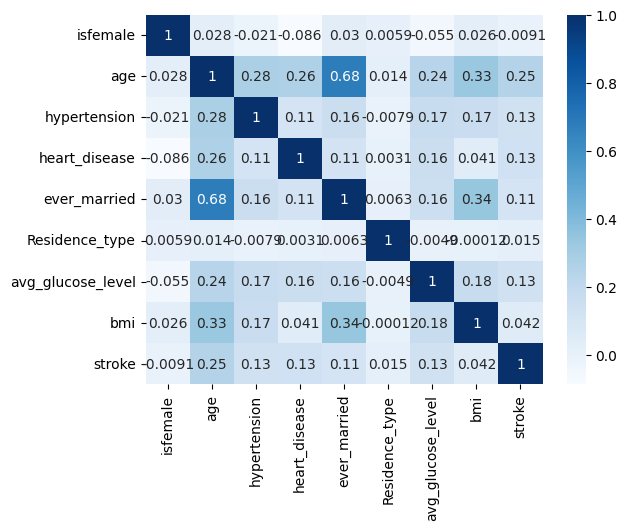

In [298]:
corr = df.corr()
sns.heatmap(data=corr, cmap='Blues', annot=True);

- The most correlated feature with the target (stroke) is age.
- Hypertension and heart disease have a weak correlation.

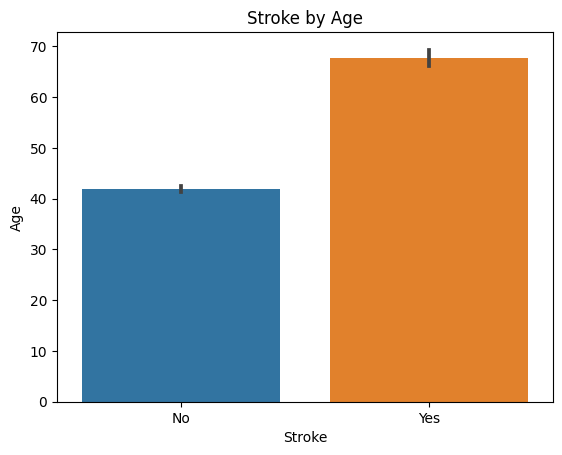

In [299]:
# barplot visual
fig, ax = plt.subplots()

sns.barplot(data=df, x='stroke', y='age')
ax.set_title('Stroke by Age')
ax.set_xlabel('Stroke')
ax.set_ylabel('Age')
plt.xticks(range(0,2), ['No', 'Yes']);

- People over 40 are more prone to having a stroke.

#**Multivariate (Multiple Variables) Exploratory Visualizations**

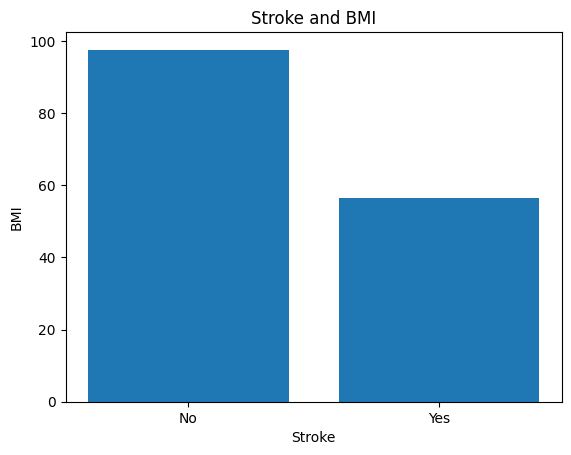

In [300]:
## Define MatplotLib fig and ax objects using plt.subplots()
fig, ax = plt.subplots()

## Use ax.bar() to create a vertical bar chart
ax.bar(df['stroke'], df['bmi'])

## Set the Title
ax.set_title('Stroke and BMI')
## Set the Y axis label
ax.set_ylabel('BMI');
ax.set_xlabel('Stroke')
ax.set_xticks(range(0, 2), ['No', 'Yes'])

- Individual with lower BMI are more likely to have a stroke.

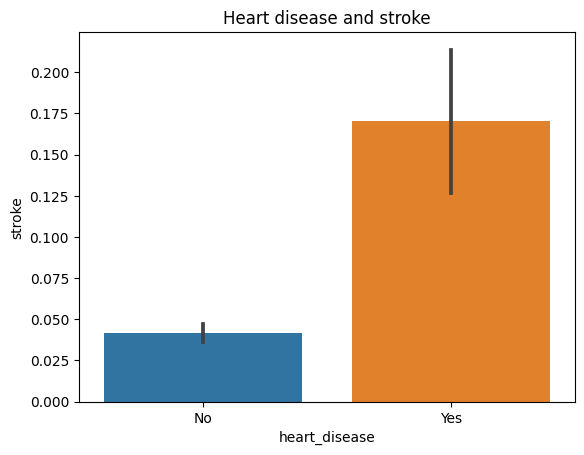

In [301]:
## Define a MatplotLib ax object using sns.barplot()
ax = sns.barplot(x= 'heart_disease', y = 'stroke', data = df)

## Set the Title
ax.set_title('Heart disease and stroke')
ax.set_xticks(range(0, 2), ['No', 'Yes']);

- Individuals with heart disease are at higher risk for a stroke.

#**Modeling**

##**Validation Split**

In [302]:
# Identify the target and features
X = df.drop(columns=['stroke'])
y = df['stroke']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

In [303]:
X_train.head()

,isfemale,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status
4505,1,60.0,1,0,1,1,234.50,43.7,never smoked
3576,0,41.0,0,0,1,0,83.97,28.5,formerly smoked
3032,0,52.0,0,0,1,1,87.51,30.5,formerly smoked
1867,1,55.0,0,0,1,0,63.47,27.8,Unknown
494,1,55.0,0,0,1,0,111.19,39.7,formerly smoked


#**Modeling: Base Model**

In [304]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')

num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_include='object')


num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(missing_imputer, ohe)

processor = make_column_transformer((num_pipe, num_cols),
                                    (cat_pipe, cat_cols))

print(processor.fit_transform(X_train).shape)

(3832, 12)


# **Logistic Regression Model**

In [305]:
# Instantiate and fit model

scores = pd.DataFrame()

logreg2 = LogisticRegression()
log_pipe2 = make_pipeline(processor, logreg2)
log_pipe2.fit(X_train, y_train)

train_pred = log_pipe2.predict(X_train)
test_pred = log_pipe2.predict(X_test)

Training Data 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.96      0.93      3832



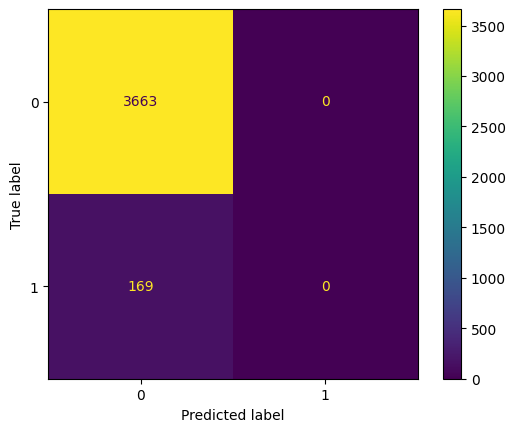

Testing Data 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



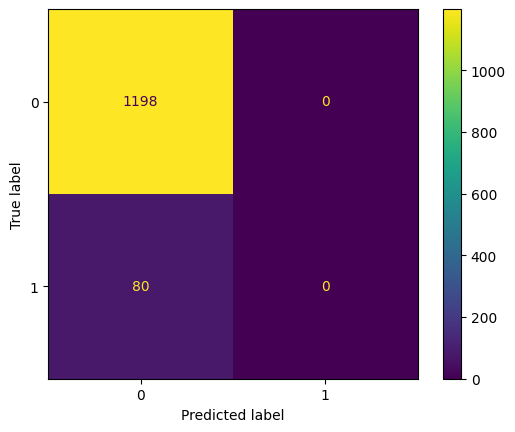

,Model Name,Precision,Recall,F1 Score,Accuracy
0,Training Data,0.0,0.0,0.0,0.955898
0,Testing Data,0.0,0.0,0.0,0.937402


In [306]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='Training Data')

test_scores = eval_classification(y_test, test_pred, name='Testing Data')

log_scores = pd.concat([train_scores, test_scores])
log_scores

- The score for train was better than test. Train is 96% precision while 94% for test. The overall accuracy is also better for train at 96% while the test score is 94%.

- The train data has a high number of false negative. It predicted 169 people with a stroke when they do not suffer a stroke. It predicted 0 false positive. Which is good but the trade off is that 169 people with a stroke were not detected. The same with the test data. It has 0 false negative but 79 people were not predicted for a stroke that would have been. Those 79 people may not get the preventive help for stroke which is bad.

# **Tune the Hyperparameters**

In [307]:
# Display the hyperparameters.
log_pipe2.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9eb57700>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                               

In [308]:
# Create a dictionary of parameters
params = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [309]:
# Tune hyperparameters with GridSearchCV
lr_gs = GridSearchCV(log_pipe2, params)
lr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9eb57700>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9f307b50>)])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                   1000]})

In [310]:
lr_gs.best_params_

{'logisticregression__C': 0.001}

In [311]:
best_lr = lr_gs.best_estimator_

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Training Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.96      0.93      3832



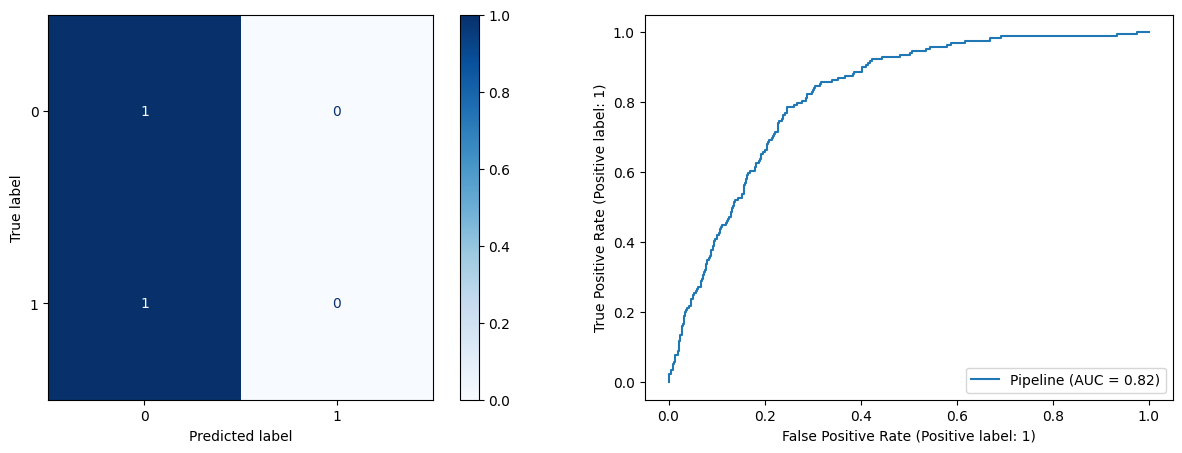

------------------------------------------------------------
[i] CLASSIFICATION REPORT FOR: Test Data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



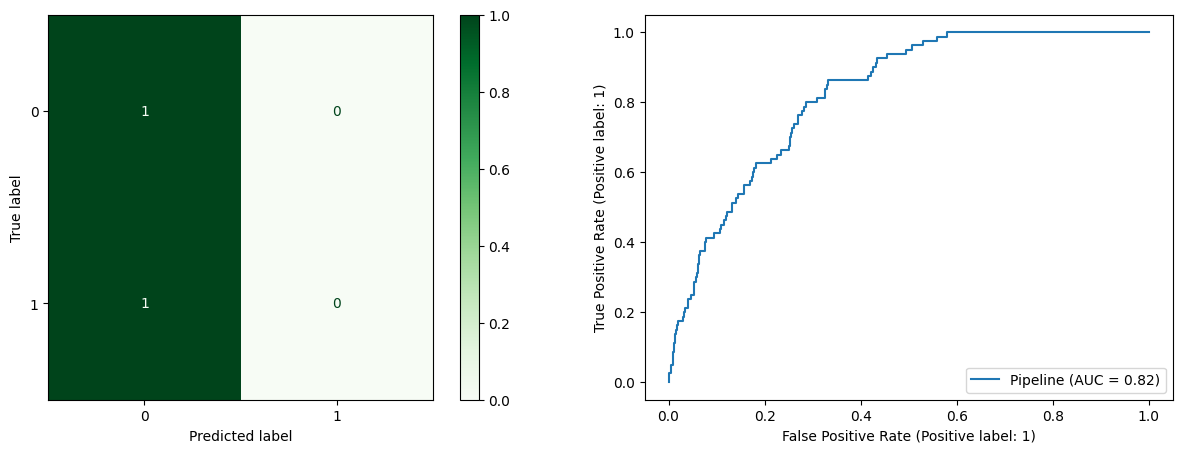

In [312]:
## Use the function twice to evaluate our model on training AND test data
classification_metrics(best_lr, X_train,y_train, thresh=.2,
                         cmap='Blues', label='Training Data')
classification_metrics(best_lr, X_test,y_test, thresh=.2,
                         cmap='Greens',label='Test Data')

#**KNN Model**

In [313]:
# Create an instance of the model
knn = KNeighborsClassifier()
# Create a model pipeline
knn_pipe = make_pipeline(processor, knn)
## Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9eb57700>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9f307b50>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

#**KNN Model Evaluation**

In [314]:
## Save the model's predictions for the train dataset
knn_train_preds = knn_pipe.predict(X_train)
## Save the model's predictions for the test dataset
knn_test_preds = knn_pipe.predict(X_test)

In [315]:
## print the classification reports
labels = ['No Stroke','Stroke']
print('Train Report')
print(classification_report(y_train, knn_train_preds, target_names=labels))

print('Test Report')
print(classification_report(y_test, knn_test_preds, target_names=labels))

Train Report
              precision    recall  f1-score   support

   No Stroke       0.96      1.00      0.98      3663
      Stroke       0.68      0.08      0.14       169

    accuracy                           0.96      3832
   macro avg       0.82      0.54      0.56      3832
weighted avg       0.95      0.96      0.94      3832

Test Report
              precision    recall  f1-score   support

   No Stroke       0.94      1.00      0.97      1198
      Stroke       0.25      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.59      0.50      0.50      1278
weighted avg       0.89      0.94      0.91      1278



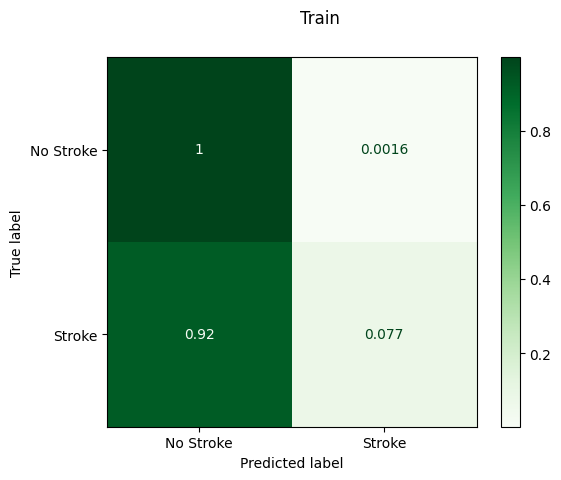

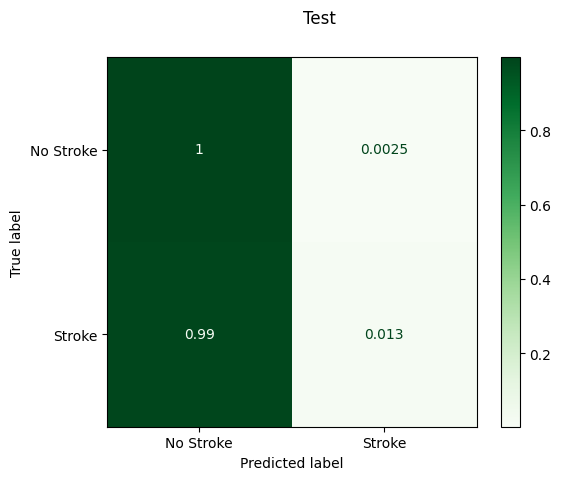

In [316]:
## create confusion matrices
ConfusionMatrixDisplay.from_predictions(y_train, knn_train_preds,
               normalize='true', display_labels=labels, cmap='Greens')
plt.suptitle('Train');



ConfusionMatrixDisplay.from_predictions(y_test, knn_test_preds,
               normalize='true', display_labels=labels, cmap='Greens')
plt.suptitle('Test');

- The train score is better than the test score with 96% precision and 94% recall. The accuracy is 94% for the whole model.

- The model is still predicting more false negative for both the train and test data. There are more false negative predicted than false positive which means more people with a stroke will not be get preventive care. The false negative number needs to be decreased.

# **Tune the Hyperparameters**

In [317]:
# Display the hyperparameters.
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9eb57700>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                               

In [318]:
# Create a dictionary of parameters
params = {'kneighborsclassifier__n_neighbors': range(1,10),
          'kneighborsclassifier__weights': ['distance','uniform']}

In [319]:
# Tune hyperparameters with GridSearchCV
knn_gs = GridSearchCV(knn_pipe, params)
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9eb57700>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9f307b50>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 10),
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']})

In [320]:
knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 8,
 'kneighborsclassifier__weights': 'uniform'}

In [321]:
knn_gs.best_score_

0.9558978216985917

In [322]:
best_knn = knn_gs.best_estimator_

In [323]:
#check the best parameter
# Instantiate and fit GridSearchCV
train_preds = best_knn.predict(X_train)
test_preds = best_knn.predict(X_test)

In [324]:
print('Train\n', classification_report(y_train, train_preds))
print('Test\n', classification_report(y_test, test_preds))

Train
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      3663
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.96      0.93      3832

Test
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



Text(0.5, 1.0, 'Test CM')

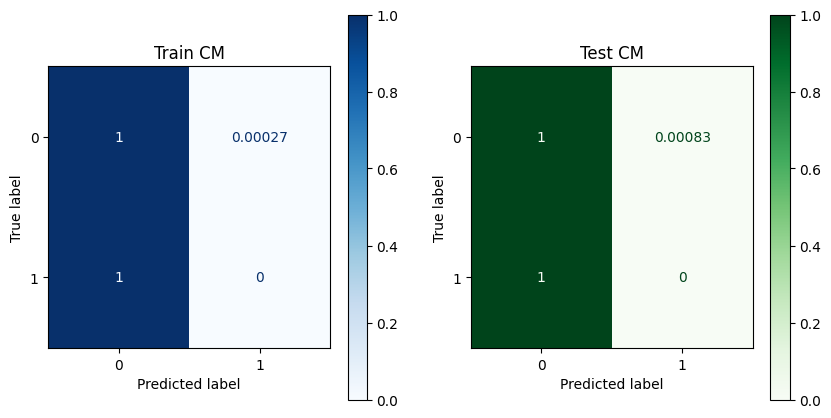

In [325]:
# Check the class balance again to help us choose a metric
# Display the test and training Confusion Matrix
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

ConfusionMatrixDisplay.from_predictions(y_train, train_preds,
                                        ax=axes[0], cmap='Blues',normalize='true')

axes[0].set_title('Train CM')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,
                                        ax=axes[1], cmap='Greens',normalize='true')

axes[1].set_title('Test CM')

# **Engineering techniques with PCA**

In [326]:
# We are asking for the number of Principal Components that will retain 95% of the variance in the original features
pca = PCA(n_components = .95)

In [327]:
%%time
# Now we will build the pipeline
knn_pca_pipe = make_pipeline(processor, pca, knn)

CPU times: user 55 µs, sys: 0 ns, total: 55 µs
Wall time: 61 µs


In [328]:
# fit the pipeline
knn_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9eb57700>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9c9f307b50>)])),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [331]:
%%time
# evaluate the pipeline
print('Training accuracy:', knn_pca_pipe.score(X_train, y_train) )
print('Test accuracy:', knn_pca_pipe.score(X_test, y_test))

Training accuracy: 0.9579853862212944
Test accuracy: 0.935054773082942
CPU times: user 266 ms, sys: 102 ms, total: 367 ms
Wall time: 265 ms


# **Production Model and Justification**

- PCA maintains 95% of data with 93% accuracy. Which is important to predict strokes.